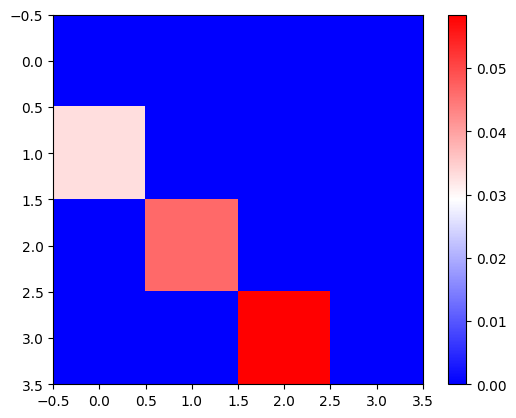

In [1]:
from simulate_data import Simulation
import numpy as np
number_of_locations = 4
n = number_of_locations
days = 60

"""
The simulation object generates model parameters on instantiation.
Simulation has methods for visualizing various model parameters.
"""
simulation = Simulation(num_locations = n, days = days)
simulation.plot_mov_ratio()

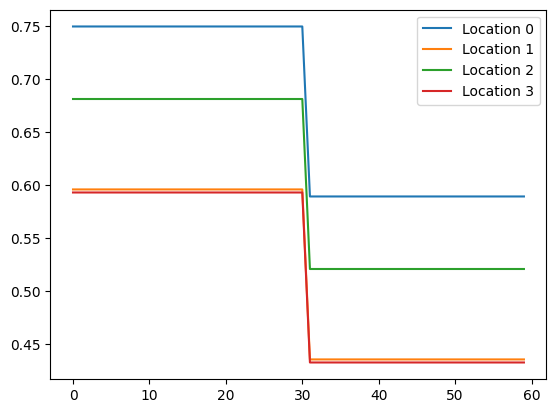

In [2]:
simulation.plot_real_beta()

In [3]:
from tau_leap import SIR_tau_leap
simulation.run_sir_model(SIR_tau_leap)

/home/andrew/Documents/code/multi-node-forecast/tau_leap.py:26: RuntimeWarning: invalid value encountered in divide
  mov_SI = np.divide(np.multiply(mov_I, mov_S), movement)


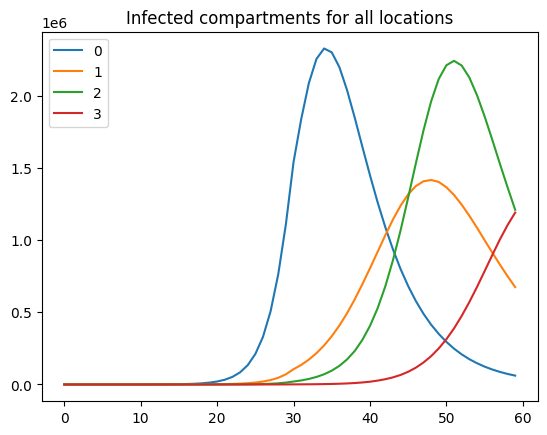

In [4]:
simulation.plot_infected()

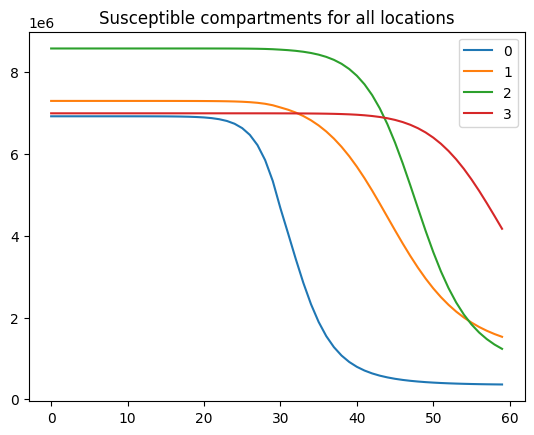

In [5]:
simulation.plot_susceptible()

We will define a new function that runs both filters at the same time. 
Then, we will compare the weights and resampling indices. 

In [6]:
from particle_filter import ParticleFilterParams

pf_params = ParticleFilterParams(
    num_particles=100,
    num_locations=simulation.num_locations,
    population=simulation.population,
    movement=simulation.movement,
    mov_ratio=simulation.mov_ratio,
    results=simulation.results,
)

In [7]:
from particle_filter import run_log_particle_filter, run_linear_particle_filter

lin_output = run_linear_particle_filter(pf_params)
log_output = run_log_particle_filter(pf_params)

Iteration: 1
Iteration: 2
Iteration: 3


/home/andrew/Documents/code/multi-node-forecast/tau_leap.py:26: RuntimeWarning: invalid value encountered in divide
  mov_SI = np.divide(np.multiply(mov_I, mov_S), movement)


Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 1 
Iteration: 2 
Iteration: 3 
Iteration: 4 
Iteration: 5 
Iteration: 6 
Iteration: 7 
Iteration: 8 
Iteration: 9 
Iteration: 10 
Iteration: 11 
Iteration: 12 
Iteration: 13 
Iteration: 14 
Iterati

In [8]:
"""Comparing the Resampling Indices"""

lin_indices = lin_output.get_all_resampling_indices_as_array()
log_indices = log_output.get_all_resampling_indices_as_array()

def check_equal_at_time_step(a, b):
    return np.array_equal(a, b)

resample_comparison_results = list(map(check_equal_at_time_step, lin_indices, 
                               log_indices))

In [9]:
print('Comparison Results per Time Step. \n`True` indicates that the '
      'resampling '
      'indices were identical at that time step'
      ':\n\n', resample_comparison_results)

Comparison Results per Time Step. 
`True` indicates that the resampling indices were identical at that time step:

 [True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


It appears that the resampling starts off equal, but something causes them to 
diverge around time step 11. I could still be missing some un-seeded 
randomness somewhere, or this could be due to numerical imprecision, where the log and 
lin weights are slowly drifitng away from each other. 

In [10]:
"""Comparing the Weights"""

import matplotlib.pyplot as plt

lin_weights = lin_output.get_all_weights_as_array()
log_weights = log_output.get_all_weights_as_array()

def convert_log_to_linear(weights):
    return np.exp(weights)

def compare_weights_at_time_step(a, b, atol=1e-8, rtol=1e-5):
    is_close = np.allclose(a, b, atol=atol, rtol=rtol)
    difference = a - b
    return is_close, difference

# Convert log weights to linear domain
log_weights_linear = convert_log_to_linear(log_weights)

# Compare each sub-array of lin_weights and log_weights_linear 
comparison_results = [
    compare_weights_at_time_step(lin_weights[i], log_weights_linear[i])
    for i in range(len(lin_weights))
]

# Extract close results and differences
close_results = [is_close for is_close, _ in comparison_results]
differences = [diff for _, diff in comparison_results]

In [11]:
print("Comparison Results:\n", close_results)

Comparison Results:
 [True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


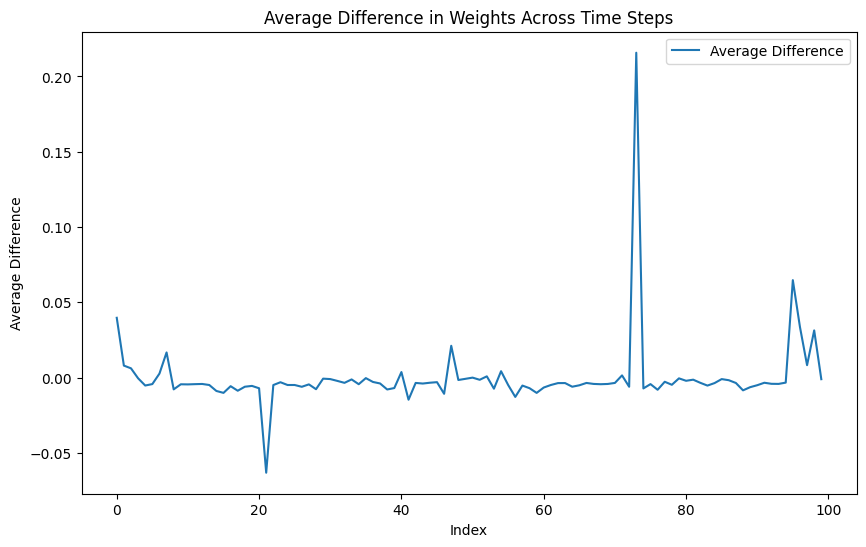

In [12]:
# Combine differences into a single array for averaging
combined_differences = np.vstack(differences)

# Calculate the average difference
average_difference = np.mean(combined_differences, axis=0)

# Plot the average difference
plt.figure(figsize=(10, 6))
plt.plot(average_difference, label='Average Difference')
plt.xlabel('Index')
plt.ylabel('Average Difference')
plt.title('Average Difference in Weights Across Time Steps')
plt.legend()
plt.show()

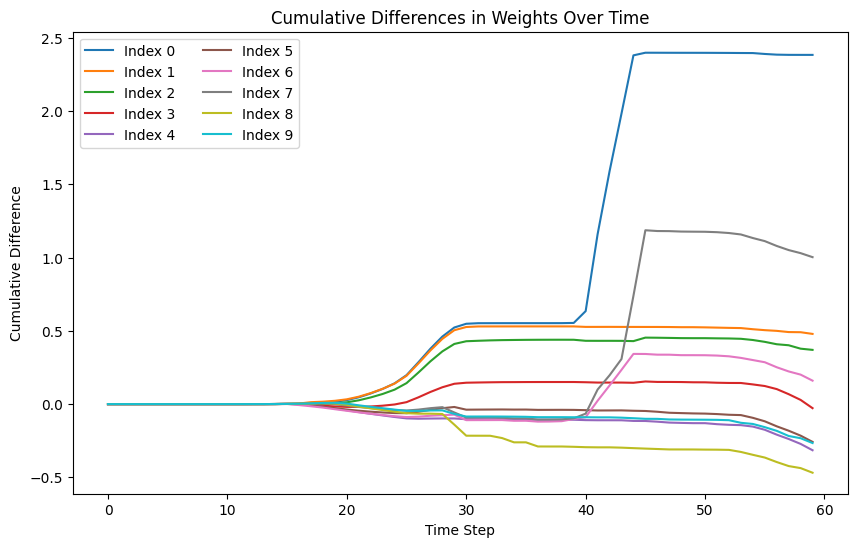

In [17]:
# Calculate the cumulative differences over time
cumulative_differences = np.cumsum(combined_differences, axis=0)

# Plot the cumulative differences for the first 5 indices
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(cumulative_differences[:, i], label=f'Index {i}')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Difference')
plt.title('Cumulative Differences in Weights Over Time')
plt.legend(loc='upper left', ncol=2)
plt.show()

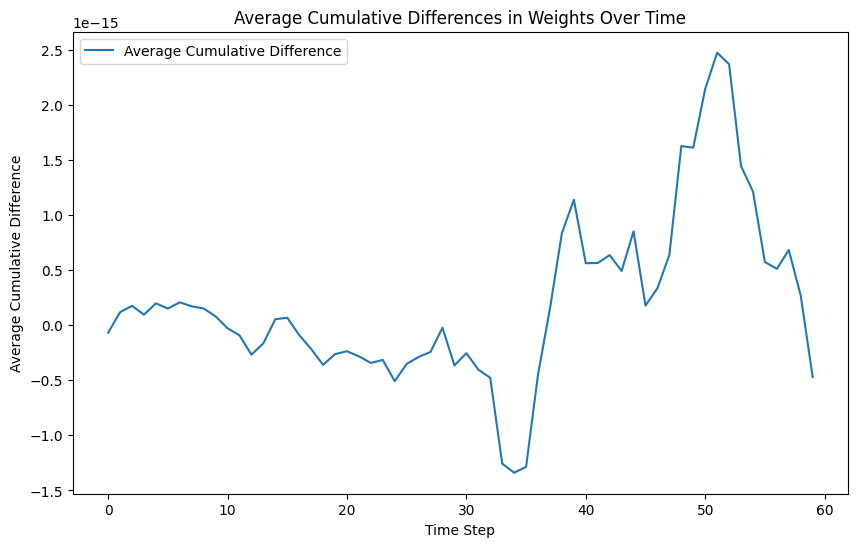

In [18]:
# Calculate the average cumulative difference across all indices
average_cumulative_difference = np.mean(cumulative_differences, axis=1)

# Plot the average cumulative difference
plt.figure(figsize=(10, 6))
plt.plot(average_cumulative_difference, label='Average Cumulative Difference')
plt.xlabel('Time Step')
plt.ylabel('Average Cumulative Difference')
plt.title('Average Cumulative Differences in Weights Over Time')
plt.legend()
plt.show()